# Proof-of-Concept kSZ Emulator

This notebook demonstrates a small proof-of-concept emulator that predicts the **binned kSZ angular power spectrum (Dl)** using 3 reionization params (zmean_zre, alpha_zre, kb_zre).

In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 400

import sys
sys.path.append("../src")
from emulator import ProofOfConceptEmulatorThreeParams

## Load Model and Normalization

In [2]:
MODEL_PATH = "../models/v1/proof_of_concept.pt"
NORM_PATH  = "../models/v1/norm"
DATA_PATH  = "../data/processed/emulator_dataset_v1.npz"

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load normalization
X_mean = np.load(f"{NORM_PATH}/X_mean.npy")
X_std  = np.load(f"{NORM_PATH}/X_std.npy")
ell    = np.load(f"{NORM_PATH}/ell.npy")

# Load model
model = ProofOfConceptEmulatorThreeParams().to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

ProofOfConceptEmulatorThreeParams(
  (fc1): Linear(in_features=3, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=5, bias=True)
  (activation): GELU(approximate='none')
)

## Predict Function

In [3]:
def predict(params):
    """
    Function to make predictions given a set of parameters.
    Input:
        params: array-like of shape (3,)
    Returns predicted Dl
    """

    params = np.array(params, dtype=np.float32)
    x_norm = (params - X_mean) / X_std

    x_tensor = torch.tensor(x_norm, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_log = model(x_tensor).cpu().numpy()

    return np.exp(pred_log)

## Load Dataset and Pick a Simulation to Compare

In [4]:
data = np.load(DATA_PATH)
X = data["X"]       # (100, 3)
Y = data["Y"]       # (100, 5)
ell = data["ell"]   # (5,)

N = X.shape[0]

rng = np.random.default_rng(seed=0)
indices = rng.permutation(N)

n_train = int(0.7 * N)
n_val   = int(0.10 * N)
n_test  = N - n_train - n_val

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

len(train_idx), len(val_idx), len(test_idx)

(70, 10, 20)

## Choose Test Sample

In [5]:
k = 0
sim_index = test_idx[k]

params = X[sim_index]
true_log = Y[sim_index]
true_dl = np.exp(true_log)

pred_dl = predict(params)

print("Test Sample Index:", sim_index)
print("Parameters:\t", params)
print("ell Bins:\t", ell)
print()
print("true log:\t\t", true_log)
print("True Dl:\t\t", true_dl)
print("Predicted Dl:\t", pred_dl)
print()
err_per_bin = np.abs(pred_dl - true_dl) / true_dl * 100
print("Error Per Bin(%):", err_per_bin)
print("Mean % Error:\t ", np.mean(err_per_bin))

Test Sample Index: 73
Parameters:	 [8.04167409 0.26472533 1.37247341]
ell Bins:	 [ 2033.49633959  4093.41528716  6153.33423472  8213.25318229
 10273.17212985]

true log:		 [0.49139486 0.46117801 0.25914031 0.10942526 0.1198826 ]
True Dl:		 [1.63459466 1.58594115 1.29581561 1.11563668 1.12736449]
Predicted Dl:	 [1.727696  1.7143229 1.3273485 1.1212641 1.1738368]

Error Per Bin(%): [5.69567983 8.09499012 2.43343705 0.50441321 4.12221083]
Mean % Error:	  4.170146205669936


## Plot True vs Predicted Dl

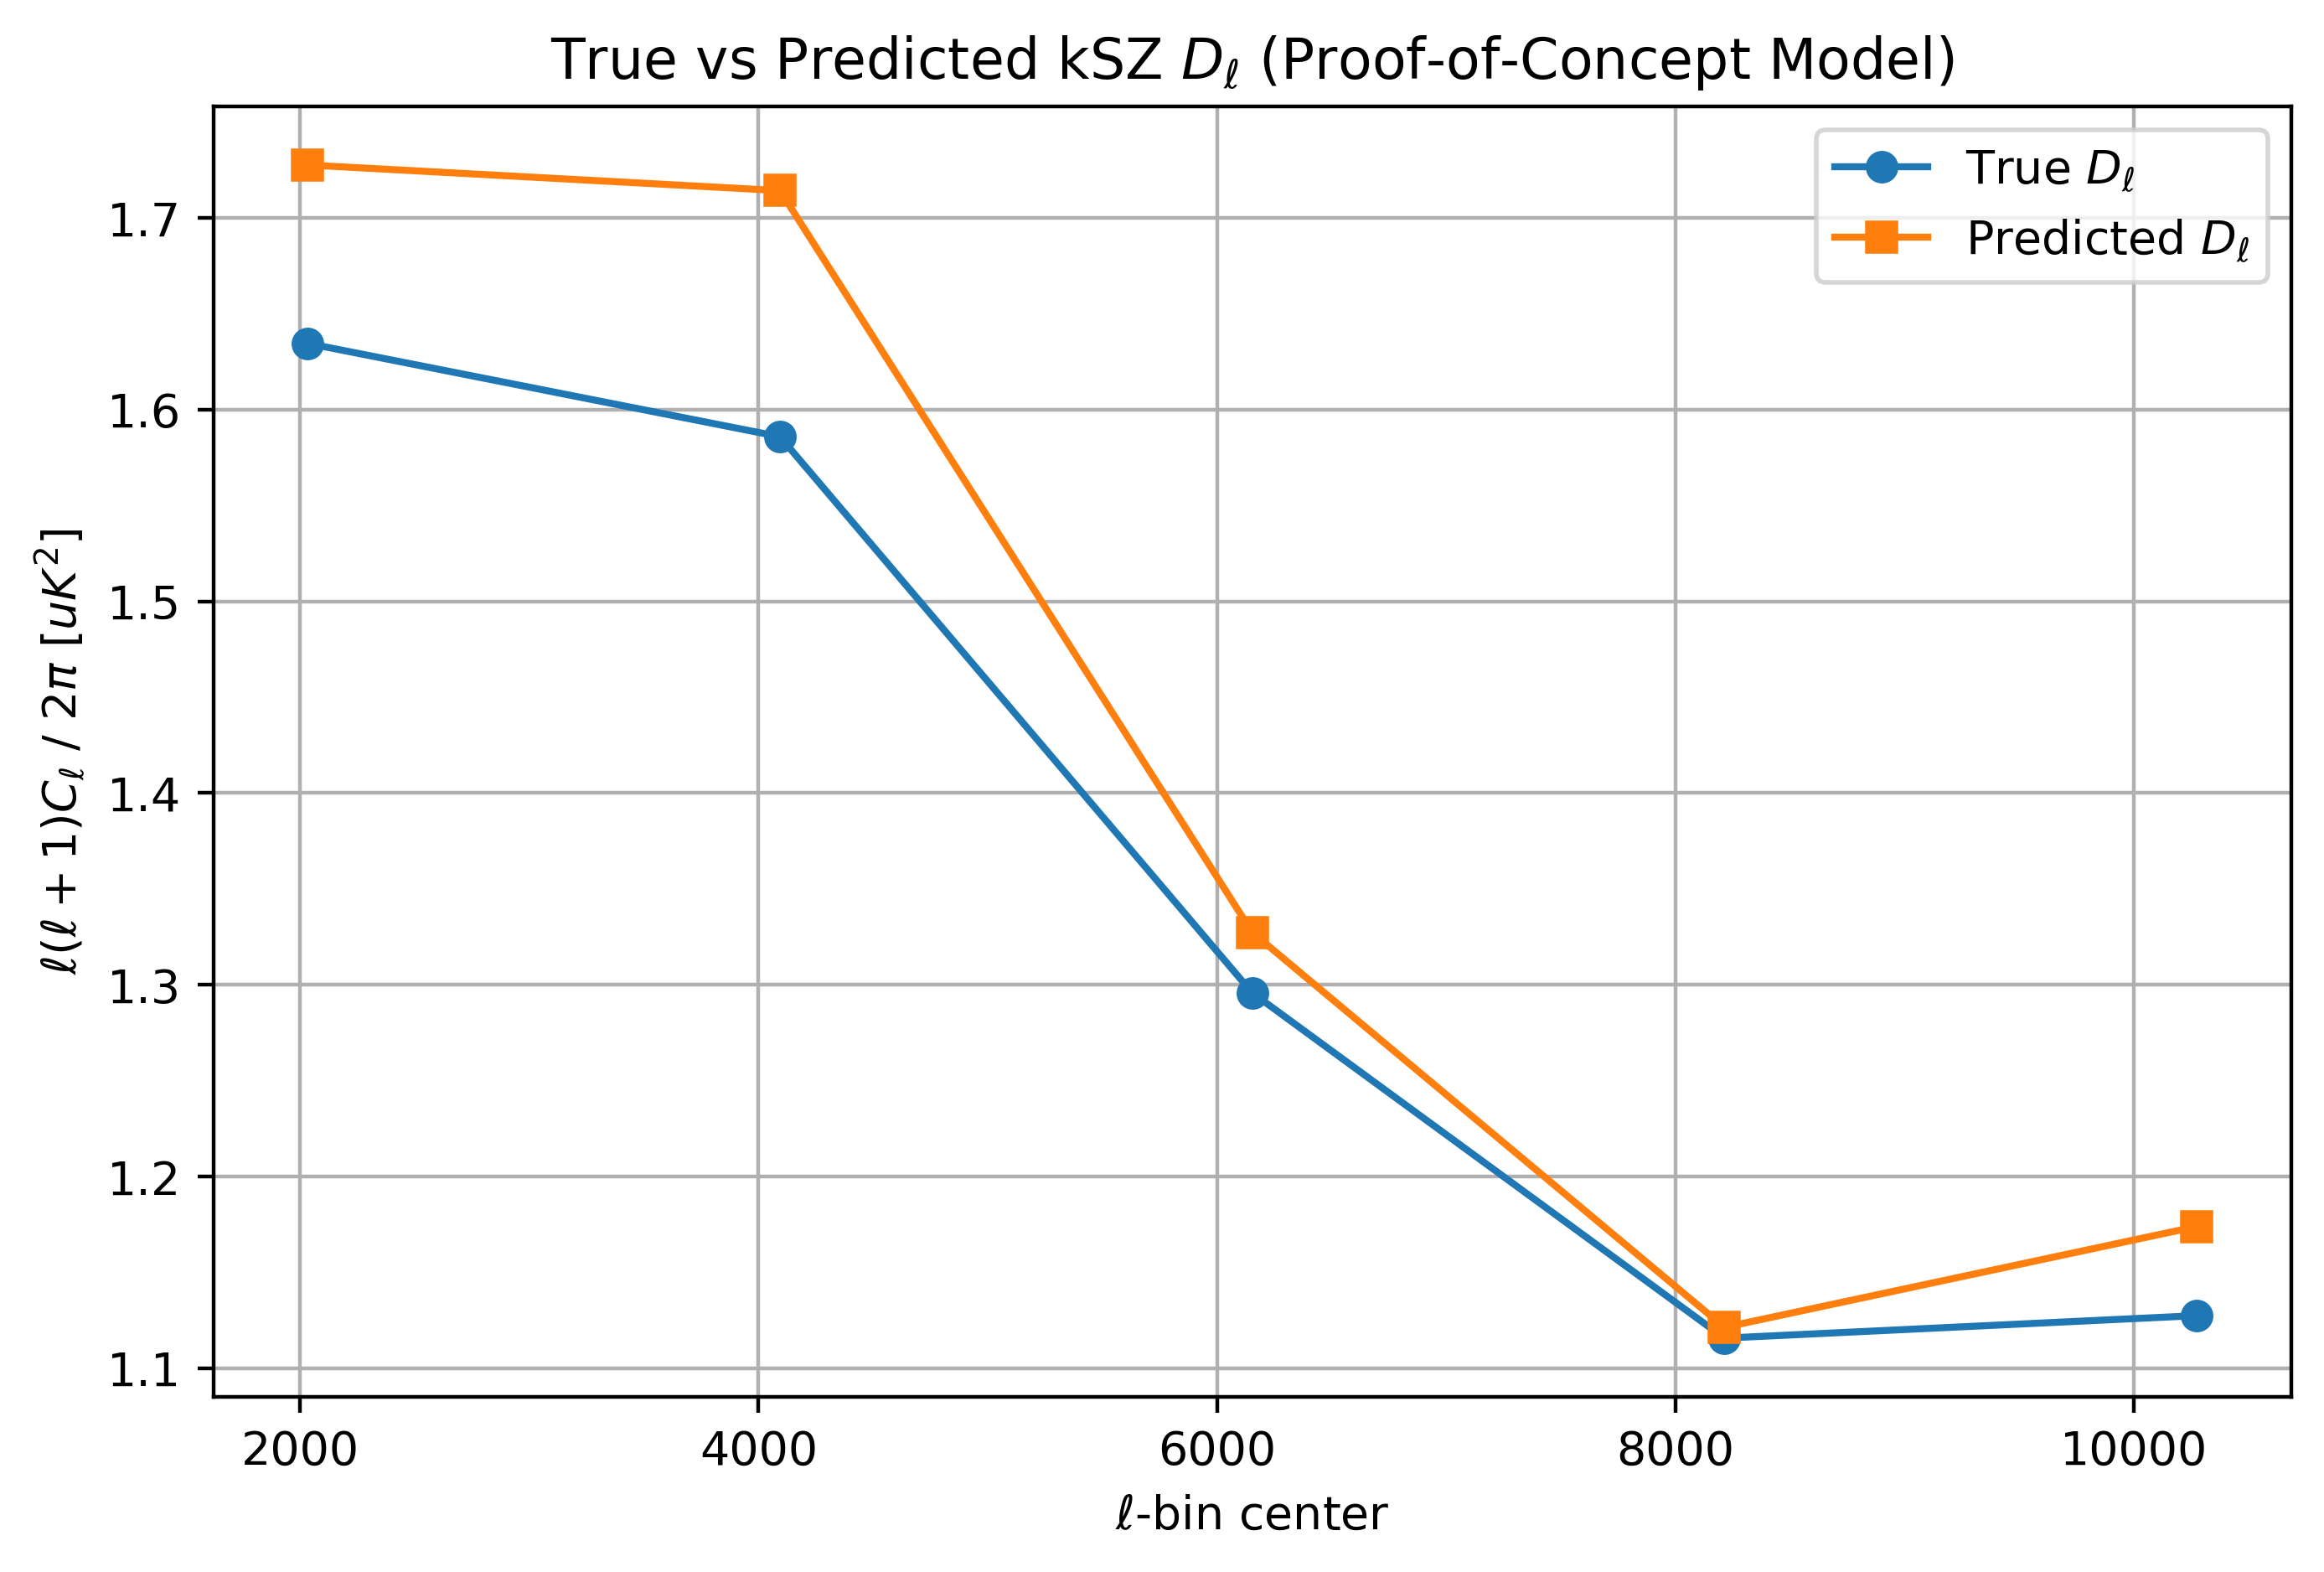

In [6]:
plt.figure(figsize=(8,5))
plt.plot(ell, true_dl, marker="o", label=r"True $D_\ell$")
plt.plot(ell, pred_dl, marker="s", label=r"Predicted $D_\ell$")

plt.title(r"True vs Predicted kSZ $D_\ell$ (Proof-of-Concept Model)")
plt.xlabel(r"$\ell$-bin center")
plt.ylabel(r"$\ell (\ell + 1)C_{\ell}$ / $2 \pi$ [$uK^2$]")
plt.legend()
plt.grid(True)
plt.show()

## Bar Chart True vs Predicted Dl

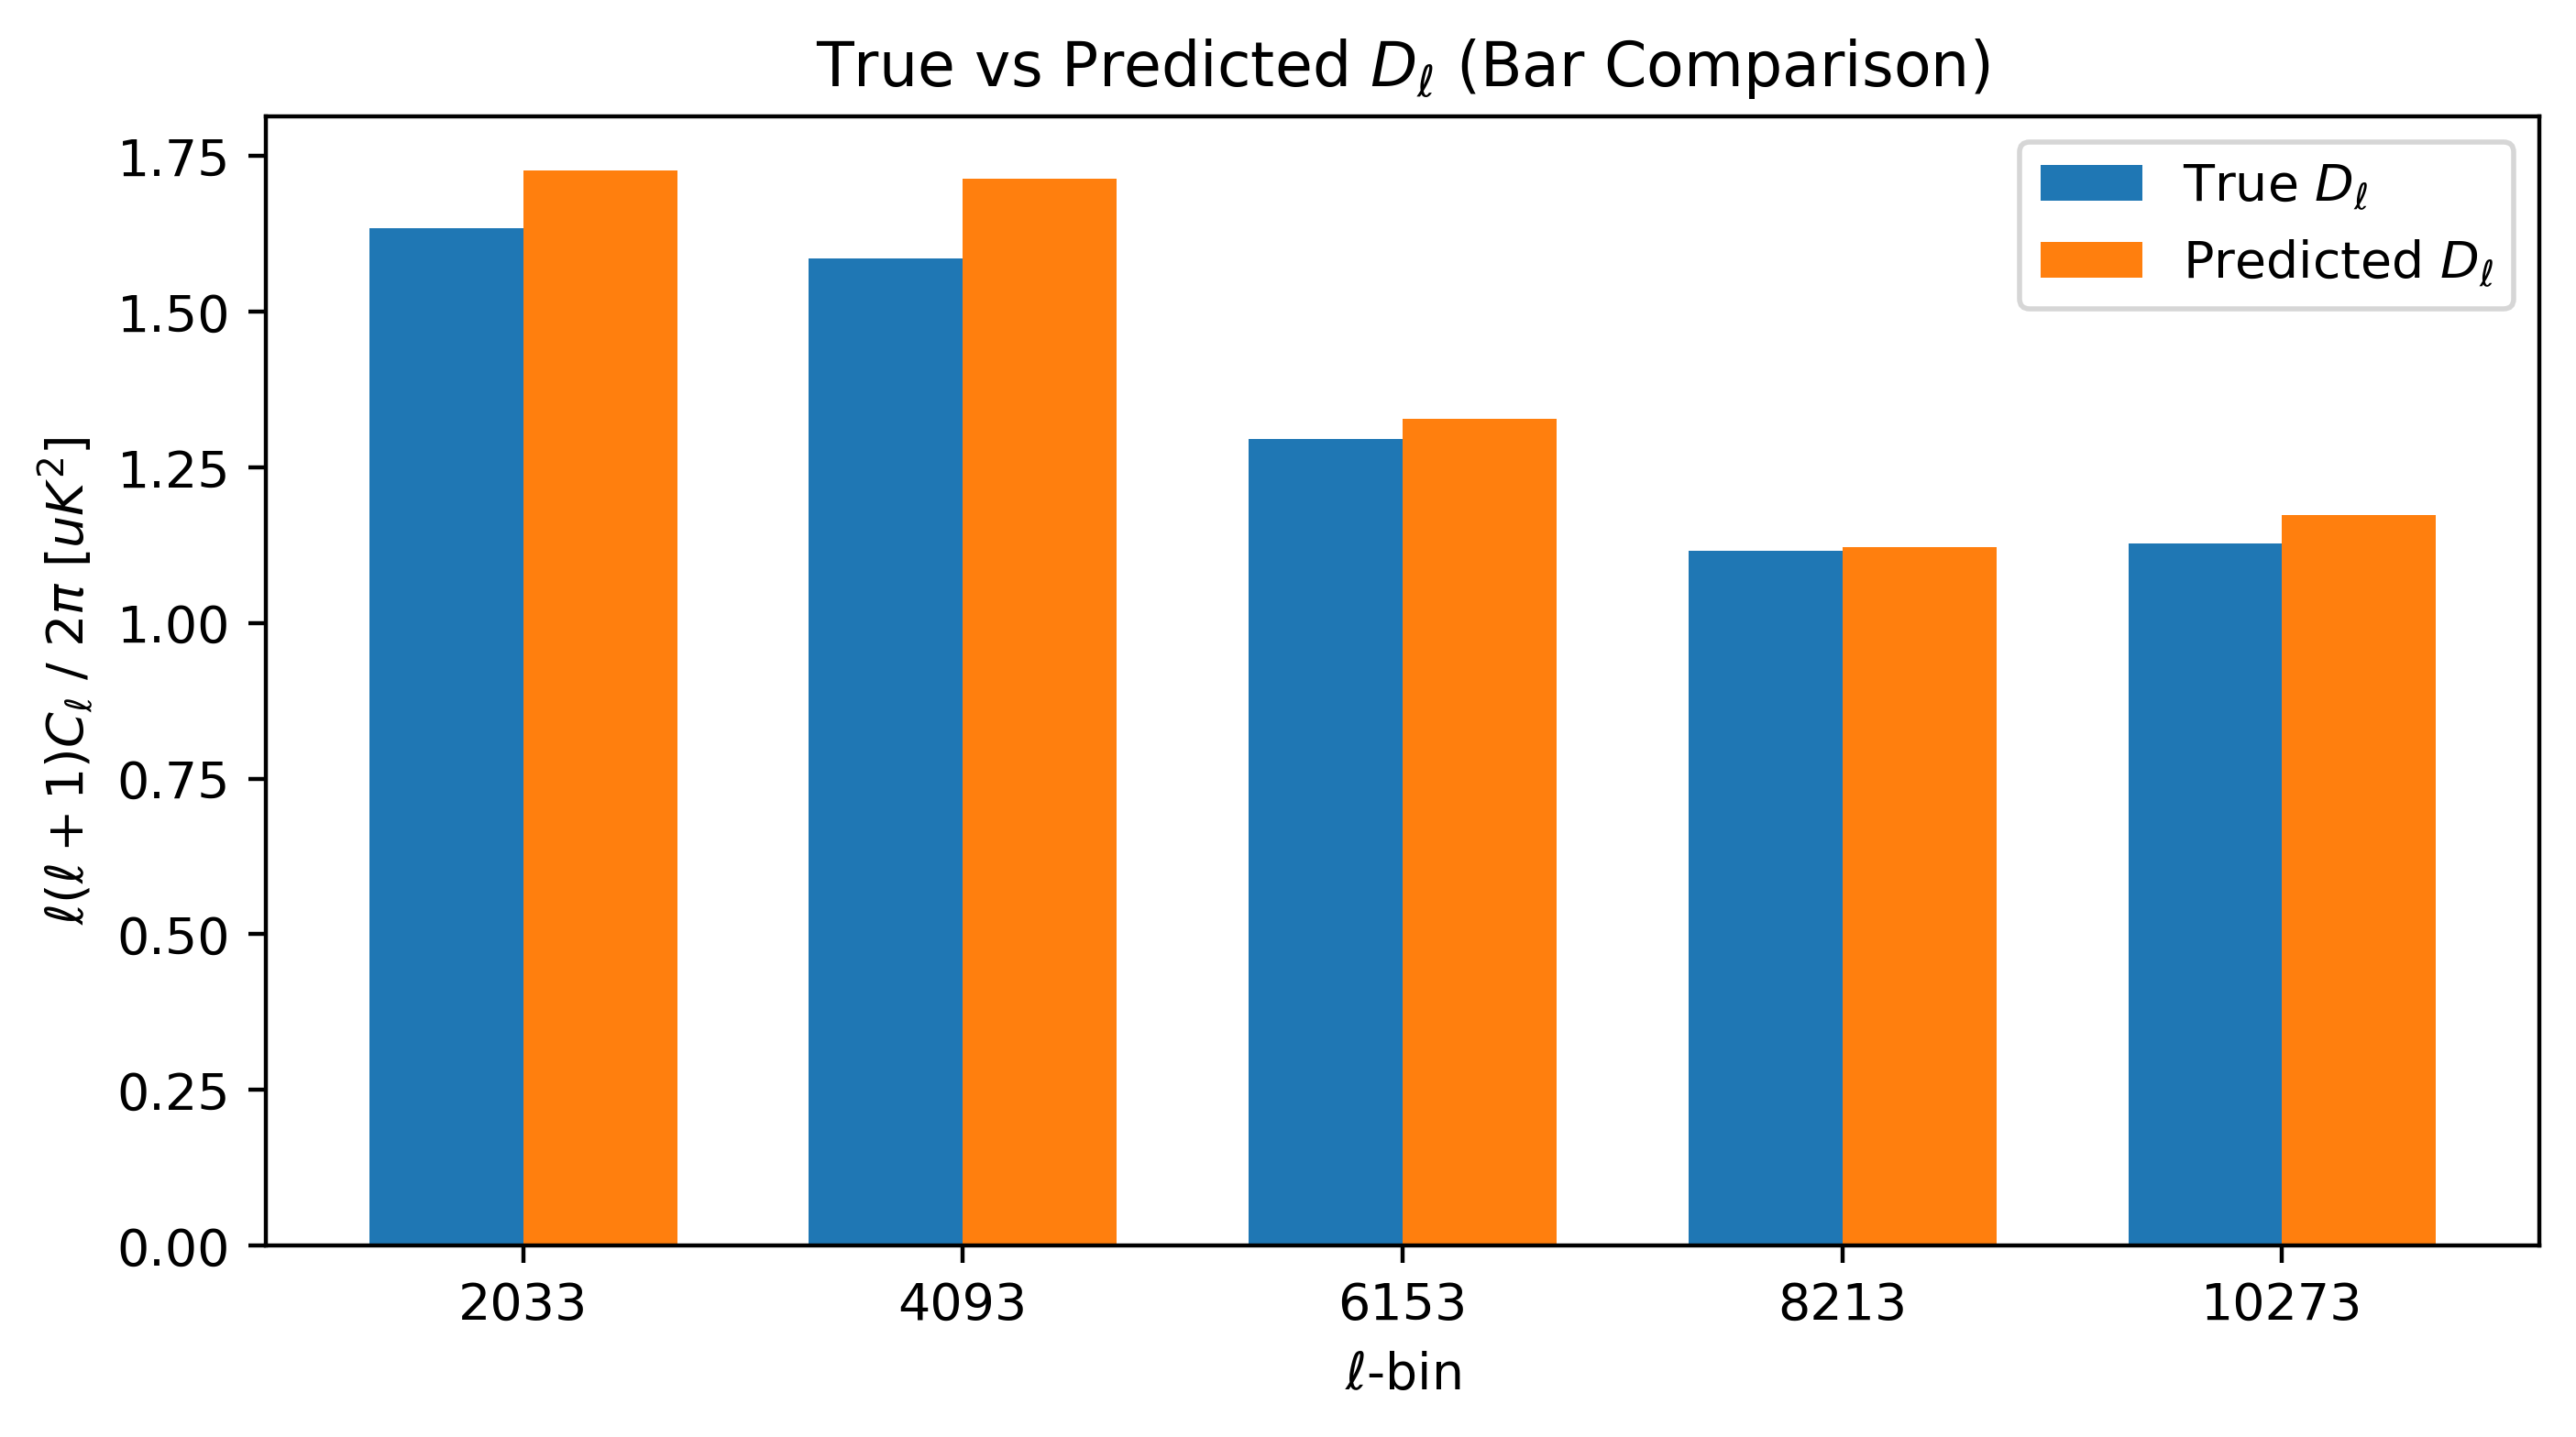

In [7]:
plt.figure(figsize=(8,4))
bins = np.arange(len(ell))
width = 0.35

plt.bar(bins - width/2, true_dl, width, label=r"True $D_\ell$")
plt.bar(bins + width/2, pred_dl, width, label=r"Predicted $D_\ell$")

plt.xticks(bins, [f"{int(e)}" for e in ell])
plt.xlabel(r"$\ell$-bin")
plt.ylabel(r"$\ell (\ell + 1)C_{\ell}$ / $2 \pi$ [$uK^2$]")
plt.title(r"True vs Predicted $D_\ell$ (Bar Comparison)")
plt.legend()
plt.show()

## Compute Error Metrics

In [8]:
mse = np.mean((true_dl - pred_dl)**2)
mae = np.mean(np.abs(true_dl - pred_dl))
percent_err = np.mean(np.abs(true_dl - pred_dl) / true_dl) * 100

print("Mean Squared Error (MSE):\t", mse)
print("Mean Absolute Error (MAE):\t", mae)
print("Mean % Error:\t\t\t\t", percent_err)

Mean Squared Error (MSE):	 0.005667079326555822
Mean Absolute Error (MAE):	 0.061023134882703986
Mean % Error:				 4.170146205669936


## Evaluate Multiple Test Sims

In [9]:
test_errors = []

for idx in test_idx:
    params = X[idx]
    true_dl = np.exp(Y[idx])
    pred_dl = predict(params)
    rel_err = np.mean(np.abs(true_dl - pred_dl) / true_dl)
    test_errors.append(rel_err)

test_errors = np.array(test_errors)

plt.hist(test_errors * 100, bins=10, edgecolor="black", linewidth=0.5)
plt.xlabel("Relative Error (%)")
plt.ylabel("Count")
plt.title("Test Set Error Distribution")
plt.show()

print("Mean Test Error (%):", np.mean(test_errors) * 100)

Mean Test Error (%): 7.883939566564973
